# FIT 5149 Assignment 2 Group 5 S2 2019: Sentiment Classification

Authors:
* Hristina Todorovska
* Asghar Mustafa
* Pouria Ebrahimnezhad

October 2019

## Preliminaries

In [ ]:
import pandas as pd
import warnings
import re
import numpy as np
from math import floor
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from scipy.sparse import vstack
from mlxtend.classifier import StackingClassifier
from fastai.text import * 
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Bidirectional, LSTM
from keras.optimizers import SGD


warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
labeled_data = pd.read_csv("/content/drive/My Drive/ADA_Assignment 2/labeled_data.csv")
unlabeled_data = pd.read_csv("/content/drive/My Drive/ADA_Assignment 2/unlabeled_data.csv")

Mounted at /content/drive


In [ ]:
# show first rows
labeled_data.head()

,text,label
0,The new rule is - \r\nif you are waiting for a...,4
1,"Flirted with giving this two stars, but that's...",3
2,I was staying at planet Hollywood across the s...,5
3,Food is good but prices are super expensive. ...,2
4,Worse company to deal with they do horrible wo...,1


In [ ]:
# show first rows
unlabeled_data.head()

,text
0,Had a good experience when my wife and I sat a...
1,On my first to Montreal with my gf we came her...
2,One of our favorite places to go when it's col...
3,"The doctor was very nice, got in in a good amo..."
4,The Nook is an immediate phoenix staple! I ca...


In [ ]:
# combine labeled and unlabeled data into one dataframe
docs = pd.concat([labeled_data, unlabeled_data])
#docs = labeled_data

In [ ]:
# print the shape of the new dataframe
print(docs.shape)

(650000, 2)


### Clean and Preprocess

Here we make a list of contractions to use in our text pre-proccessing which we think will be able to result in better features in our sentiment analysis

In [ ]:
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"}

We also generate a customised list of stop words that can be used towards sentiment analysis, since using the English stop words can actually remove some of the words that play a key role in classification of the labels

In [ ]:
our_stop_words = ['i', 'I',
'me',
'my',
'myself',
'we',
'our',
'ours',
'ourselves',
'you',
"you're",
"you've",
"you'll",
"you'd",
'your',
'yours',
'yourself',
'yourselves',
'he',
'him',
'his',
'himself',
'she',
"she's",
'her',
'hers',
'herself',
'it',
"it's",
'its',
'itself',
'they',
'them',
'their',
'theirs',
'themselves',
'what',
'which',
'who',
'whom',
'this',
'that',
"that'll",
'these',
'those',
'am',
'is',
'are',
'was',
'were',
'be',
'been',
'being',
'have',
'has',
'had',
'having',
'do',
'does',
'did',
'doing',
'a',
'an',
'the',
'and',
'but',
'if',
'or',
'until',
'while',
'of',
'at',
'by',
'for',
'with',
'about',
'between',
'into',
'during',
'before',
'after',
'to',
'from',
'in',
'out',
'on',
'then',
'once',
'here',
'there',
'when',
'where',
'all',
'both',
'each',
'other',
'some',
'such',
'only',
'own',
'same',
'so',
'than',
's',
't',
'can',
'will',
'just',
'now',
'd',
'll',
'm',
'o',
're',
've',
'y',
'ain',
'aren',
"aren't",
'ma',
'needn',
"needn't",
'shan',
"shan't",]

In [ ]:
# Tokenization
tokenizer = RegexpTokenizer('\w+(?:[-\']\w+)?')

# Lemmatization    
lemmatizer = WordNetLemmatizer() 

REPLACE_WITH_SPACE = re.compile("(!)|(\.)|(\?)")

def lemma(doc):
    temp=[]
    for each in doc:
        temp.append(lemmatizer.lemmatize(each))
    return temp 
  


Now in order to make life easier we define a function that can pre process our data this would come in handy later in our modelling and testing stage

In [ ]:
def pre_process(text):
  
  
    # convert to lowercase
    text = text.apply(lambda x: x.lower())
    
    # remove url
    text = text.apply(lambda x : re.sub(r"http\S+", "", x))
    
    # remove numbers
    text = text.apply(lambda x: re.sub(r"\d+", "", x))
    
    # replace apostrophe/short words
    for key, value in contractions.items():
        text = text.apply(lambda x: x.replace(key, value))
    
    # remove Punctuation
    text = text.apply(lambda x: re.sub(r'[^\w\s]',' ',x))
    
    # remove whitespaces
    text = text.apply(lambda x: re.sub('\s+', ' ', x).strip())
    
    # Removing our own set of stopwords from the vocab
    text = text.apply(lambda x : ' '.join([word for word in x.split() if word not in our_stop_words]))
    
    # tokenization
    text = text.apply(lambda x: tokenizer.tokenize(x))
    
    # lemmatization
    text = text.apply(lambda x: lemma(x))
    
    return text
    


In [ ]:
text = docs.copy()

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Pre Processing our Train Data

Here we apply the pre defined funstion for pre processing to our data

In [ ]:
%%time
text["text"] = pre_process(text["text"])

CPU times: user 7min 2s, sys: 2.2 s, total: 7min 4s
Wall time: 7min 4s


Computing TF-IDF and Extracting Keywords

in this section we compute the term frequency and Inverse document frequency of the words which will be then used to create a dataframe of our features for modeling stage, for now we will keep the maximum number of features to 10,000

In [ ]:
tfidf_rep = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False,analyzer='word', ngram_range=(1, 3),  min_df=0.0, max_features=10000, stop_words=our_stop_words)
tfv_matrix = tfidf_rep.fit(text.iloc[0:50000]["text"])
tfv_matrix_all = tfidf_rep.transform(text["text"])
tfv_features = tfidf_rep.get_feature_names()

In [ ]:
df_labeled=tfv_matrix_all[0:50000,:]
df_unlabeled=tfv_matrix_all[50000:,:]

In [ ]:
df_data = pd.DataFrame(tfv_matrix_all[0:50000].toarray(),columns=tfv_features)
df_data.shape


(50000, 10000)

In [ ]:
def accuracy(list1,list2):
    match=0
    for i in range(len(list1)):
        if list1[i]==list2[i]:
            match+=1
    return (match/len(list1))

## Exploratory Data Analysis

### Perform PCA on the features

Here we try to perform Principal Component Analysis on the features with an aim to understand how much of the variance is explained by which components of our features.

in order to do this we scale the data and apply the analysis to non scaled data just to observe the differences

also we try and demonstrate how much of the verience is explained by how many components

In [ ]:
# PCA requires scaling the data, here we decide to visualise both with and without scaling the features

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = df_data.columns.tolist()

# Separating out the features
x = df_data.loc[:, features].values

# Standardizing the features
x_s = StandardScaler().fit_transform(x)

In [ ]:
pca = PCA(n_components=1000).fit(x_s)


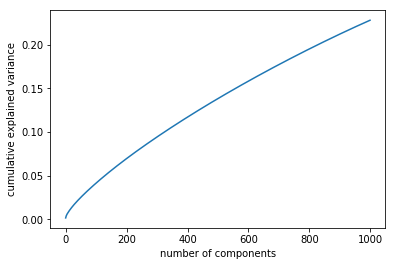

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We tried to Analyse the full number of components but due to limiatations in memory this was not feasible we can see here that the first 1000 principal components of our fetures only explains an accumulated 25-30% of the variance.

In [ ]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(x_s)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [ ]:
# Projection to 2D

pca_s = PCA(n_components=2)
principalComponents_s = pca_s.fit_transform(x_s)
principalDf_s = pd.DataFrame(data = principalComponents_s
             , columns = ['principal component 1', 'principal component 2'])


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [ ]:
# Generating a Dataframe including the 1st and 2nd components and the lable
finalDf_s = pd.concat([principalDf_s, text.iloc[0:50000]["label"]], axis=1)
finalDf = pd.concat([principalDf, text.iloc[0:50000]["label"]], axis=1)

In [ ]:
finalDf.head()

,principal component 1,principal component 2,label
0,0.033303,-0.022360,4
1,-0.001126,0.171278,3
2,-0.089108,-0.010229,5
3,-0.025735,0.024445,2
4,0.143270,-0.051574,1


Now we visualise all 5 classes of our data with respect to their 1st 2nd components but here we have not scaled the features

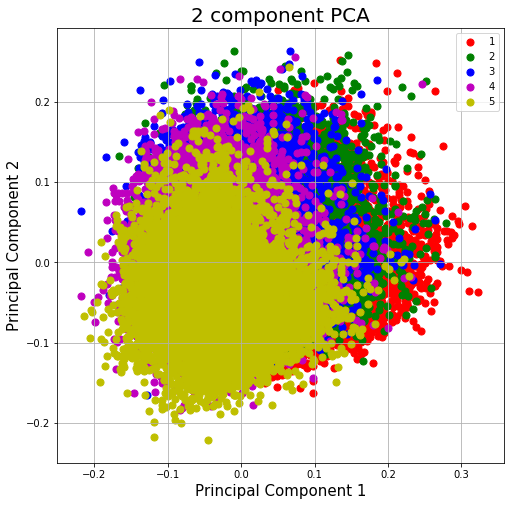

In [ ]:
# Visualize 2D Projection not scaled features

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
labels = [1,2,3,4,5]
colors = ['r', 'g', 'b', 'm', 'y']
for label, color in zip(labels,colors):
    indicesToKeep = finalDf['label'] == label
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

We now perform the same excersize for the scaled features, as expected there is no distinct seperation between the classes based on the 1st two components of the features meaning they do not explain significant portion of the variance

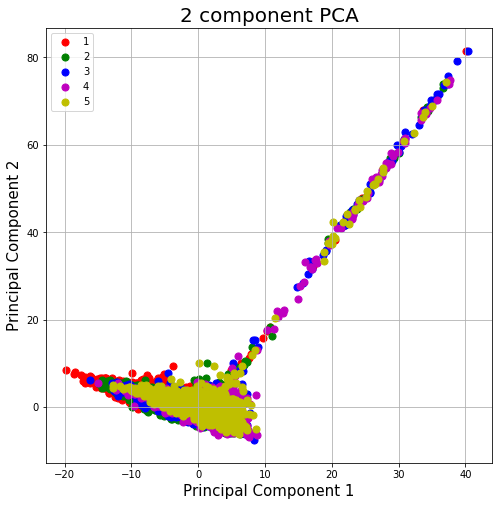

In [ ]:
# Visualize 2D Projection with scaled features

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
labels = [1,2,3,4,5]
colors = ['r', 'g', 'b', 'm', 'y']
for label, color in zip(labels,colors):
    indicesToKeep = finalDf_s['label'] == label
    ax.scatter(finalDf_s.loc[indicesToKeep, 'principal component 1']
               , finalDf_s.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(labels)
ax.grid()

In [ ]:
# How much of the data is explained by the 1st two components of the features
pca_s.explained_variance_

array([14.94351969, 13.93026922])

## Creating Models

in this section we try and fit various models of choice in dealing with sentiment analysis.

We use a 20% split of the labled data at this stage only, meaning we will train the models with 40,000 data points and test on 10,000 

we then use the accuracy method created to see how well the models perform on this test split.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_data, text.iloc[0:50000]["label"], test_size=0.2, random_state = 200)

### MultinomialNB

In [ ]:
clf = MultinomialNB().fit(X_train, y_train)
clf_predict = clf.predict(X_test)
accuracy(clf_predict,y_test.values)

0.569

### Logistic Regression

In [ ]:
lr1 = LogisticRegression(random_state=0, solver='lbfgs', class_weight="balanced", multi_class='multinomial').fit(X_train, y_train)
lr_predict1=lr1.predict(X_test)
accuracy(lr_predict1,y_test.values)

0.6041

We try the logistic regression with a different solver function and also change some further parameters such as penalty and tol level

In [ ]:
lr2 = LogisticRegression(random_state=0, solver='newton-cg', C=0.6, class_weight="balanced", fit_intercept=False, max_iter=250, penalty="l2",tol=0.0001,multi_class='multinomial').fit(X_train, y_train)
lr_predict2=lr2.predict(X_test)
accuracy(lr_predict2,y_test.values)

0.6039

### Linear SVC

In [ ]:
lc = LinearSVC()
clf3  = lc.fit(X_train, y_train)
calibrated_svc = CalibratedClassifierCV(base_estimator=clf3, cv = "prefit")
calibrated_svc.fit(X_train, y_train)
clf_predict = calibrated_svc.predict(X_test)
accuracy(clf_predict,y_test.values)

0.5629

Comparing the above models it is clear that the logistic regression model seems to be performing the best on our data set. now we will move to Neural networks models to see if we can improve on this accuracy any further without using the unlabled data.

### Neural Network - Keras Implementation

Here we try to see how a Neural Network would perform on our labled data.

for this section we first try defining multi layered Neural network and 100 epochs to see how the test data vs the train data performs in terms of loss and accuracy. we visualise the findings by ploting the results for each epoch or iteration

we then try and choose the best optimal parameters and fit the final model.

In [ ]:
# creating an input dimension variable

input_dim = X_train.shape[1]  # Number of features
input_dim

10000

In [ ]:
# 1st Implementation
model = Sequential()
model.add(layers.Dense(6, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6)                 60006     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 42        
Total params: 60,048
Trainable params: 60,048
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 2nd implementation
model = Sequential()
model.add(Dense(31, activation='relu', input_dim=input_dim))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 31)                310031    
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 192       
Total params: 310,223
Trainable params: 310,223
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=100, verbose=False, validation_data=(X_test, y_test), batch_size=128)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8469
Testing Accuracy:  0.5436


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

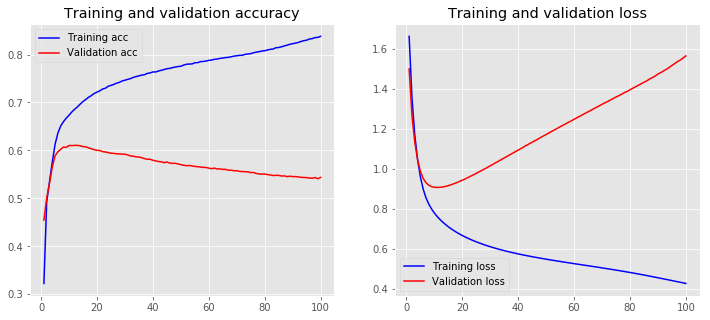

In [ ]:
plot_history(history)


from the above graph we could see that the validation graph shows a fast increase in the accuracy for the first couple of epochs but after that tends to drop and the loss shows the reverse trend which is as expected this shows that we can tune the model for optimal number of iterations and number of layers.

based on the ablove we will now try fitting the model with 6 epoch and batch_size of 128 and then evaluate the model on the train and test sets

In [ ]:
# Training on Train and Test split
history = model.fit(X_train, y_train, epochs=6, verbose=False, validation_data=(X_test, y_test), batch_size=128)


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8059
Testing Accuracy:  0.6588


#### Cross Validation with NN

Now inorder to see the overall performance of our Neural Network model from above we apply 10-Fold Cross validation to the model and train with multiple test and train splits to see how the overall model variance is on different splits

In [ ]:
# fix random seed for reproducibility

seed = 7
np.random.seed(seed)

# split into input (X) and output (Y) variables
X = df_data
Y = pd.DataFrame(text.iloc[0:50000]["label"])

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

for train, test in kfold.split(X, Y):
  model = Sequential()
  model.add(Dense(31, activation='relu', input_dim=input_dim))
  model.add(Dense(6, activation='softmax'))
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
  model.fit(X.ix[train], Y.ix[train], epochs=6, batch_size=128, verbose=False)
  scores = model.evaluate(X.ix[test], Y.ix[test], verbose=False)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

acc: 61.20%
acc: 60.56%
acc: 61.61%
acc: 60.45%
acc: 62.07%
acc: 59.83%
acc: 62.53%
acc: 60.21%
acc: 61.30%
acc: 59.40%
60.91% (+/- 0.95%)


From above we can see that the model is performing consistently with an average accuracy of 60.91% on 10 folds of split between test and train data.

in the next step we look to a different version of Neural Networks the CNN to see if we can improve on this score even further using the labled data

### Implementing convolutional neural network with Keras tokenizer and GloVe embedding

Here we try another form of the neural network which is known to be good on image analysing but also good with text analysis, the aim here is to see if we can improve the results from the last model

In [ ]:
X = text['text'].tolist()

In [ ]:
y = text['label'].tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/ADA_Assignment 2/glove_6B_100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Activation, Dropout, Bidirectional, LSTM, Embedding, Conv1D, GlobalMaxPooling1D
from keras.optimizers import SGD

model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          5051500   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 60006     
Total params: 5,111,506
Trainable params: 60,006
Non-trainable params: 5,051,500
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 14s 442us/step - loss: 1.1876 - acc: 0.4776 - val_loss: 0.9878 - val_acc: 0.5666
Epoch 2/6
32000/32000 [==============================] - 13s 420us/step - loss: 0.7479 - acc: 0.7035 - val_loss: 1.0682 - val_acc: 0.5454
Epoch 3/6
32000/32000 [==============================] - 13s 420us/step - loss: 0.3438 - acc: 0.8881 - val_loss: 1.3558 - val_acc: 0.5302
Epoch 4/6
32000/32000 [==============================] - 14s 426us/step - loss: 0.1044 - acc: 0.9750 - val_loss: 1.6733 - val_acc: 0.5229
Epoch 5/6
32000/32000 [==============================] - 14s 425us/step - loss: 0.0288 - acc: 0.9962 - val_loss: 1.9158 - val_acc: 0.5246
Epoch 6/6
32000/32000 [==============================] - 14s 426us/step - loss: 0.0096 - acc: 0.9994 - val_loss: 2.1036 - val_acc: 0.5235


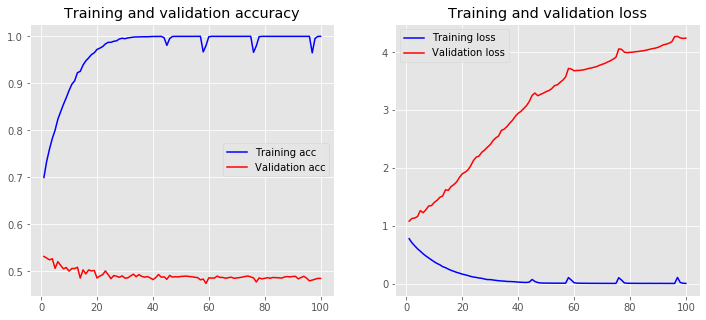

In [ ]:
plot_history(history)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8939
Testing Accuracy:  0.5008


We can see that this model is not performing better than the previous simple Neural network model we tuned for our data

## Final Classifier

### FAST.AI ULMFIT language modelling Classifier (Deep Learning Model)

Now we try a different model that we reasearched and has been known to have good performance on multi language text data.

Setting up labelled data for use in the Language Modeller and the deep neural network text classifier using (Universal Language Model Fine-tuning).

In [ ]:
cols = labeled_data.columns.tolist()

cols = cols[-1:] + cols[:-1]
labeled_data=labeled_data[cols]
labeled_data.head()

,label,text
0,4,The new rule is - \r\nif you are waiting for a...
1,3,"Flirted with giving this two stars, but that's..."
2,5,I was staying at planet Hollywood across the s...
3,2,Food is good but prices are super expensive. ...
4,1,Worse company to deal with they do horrible wo...


Setting up train and test data for model validation

In [ ]:
df_trn, df_val = train_test_split(labeled_data, stratify = labeled_data['label'], test_size = 0.3)

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [ ]:
data_clas.show_batch()

text,target
"xxbos xxmaj okay , stayed here xxmaj mon . , xxmaj oct. 21st - xxmaj fri . , xxmaj oct. 25th . xxup omg ! xxmaj what a nightmare ! i will never stay here until renovations are done . xxmaj there is two major pros ... price ( it 's so cheap ! ) and location , location , location . xxmaj seriously , you 're dab smack in",1
"xxbos xxmaj if your discharged patient into rehab is at all un alert , too trusting , goes with flow , ca n't or wo n't speak up for themselves xxrep 4 . \r \n \r \n xxup avoid xxup avoid xxup avoid and if you ca n't -- watch them 16 hours a day . \r \n \r \n xxmaj they deliver breathing treatments and anything highly",1
"xxbos xxup cj , a manager , had contacted me and asked me to call him about my experiences . xxmaj we chatted and i said i would give them another try . \r \n \r \n xxmaj amy recognized me ( good or bad , i was impressed ) and made no bones about apologizing for that first night and expressing her hope that this time would be",2
xxbos xxmaj little xxmaj bavaria has the xxup worst xxup german xxup food myself or my fiancee have ever eaten . xxmaj we walked out feeling like we had taken a wrong turn into a xxmaj berlin ghetto & suffered a xxunk at the hands of ruthless xxunk . xxmaj let me explain why we had one of the worst food experiences of our lives ... \r \n \r \n,1
xxbos xxmaj great xxmaj local xxmaj casino and xxmaj hotel ! xxmaj great service ! xxmaj appreciative staff ! \r \n \r \n i think this place is a great location for a local casino xxup and hotel . xxmaj first off they have friendly staff though of course i ca n't say xxup every person . xxmaj some hosts are better than others but the front desk staff,4


#### Language Modeller

Setting up the language modeller for the text classifier we require for the model

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Finding the optimum initial learning rate for the language modeller. The graph below shows the optimal rate to be 1.91E-02.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 1.74E-02


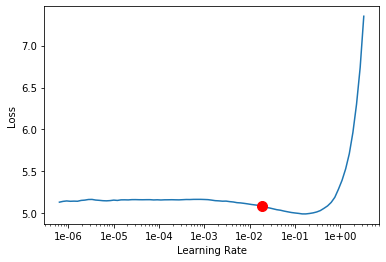

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

Initial training of the language modeller on the Yalp labeled data set. 

In [ ]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.151972,4.007540,0.269339,12:44
1,3.880154,3.839057,0.284353,12:44


Further training of the modeler with smaller learning rate to improve accuracy.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.595788,3.657437,0.305355,14:58
1,3.413057,3.599689,0.313078,14:58


Saving language encoder for future use.

In [ ]:
learn.save_encoder('ft_enc')

#### ULMFit Text Classifier (RNN classifier)

Setting up the classifier for predictions.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (35000 items)
x: TextList
xxbos xxmaj we got in just before midnight , had a friend who had a table come out to get us and even though they already used all their comps , the bouncers were nice enough to still let us in for free . xxmaj it 's not as glamorous or spacious as xxup xs and has more of a lounge - y feel to it , but i liked the crowd better . xxmaj the night i was there , it was a waaay older crowd but still fun nonetheless ! xxmaj small dance floor but huge outdoor patio with tons and tons of cabanas .,xxbos xxmaj kind of like an over - priced , over - packed goodwill . xxmaj except , the customer service is worse here . : / 
 
 
 
  i hate leaving bad reviews but the workers here just do n't seem to want to work , or help , or even bother to be very friendly . 
 
  i used my xxmaj groupon so now i do n't have to go back ...,xxbos xxmaj the food at xxmaj ravi xxmaj soups makes for a quick and moderately priced lunch . xxm

Finding optimal learning rate for text classifier. From the graph, it is 1.45E-02.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 1.74E-02


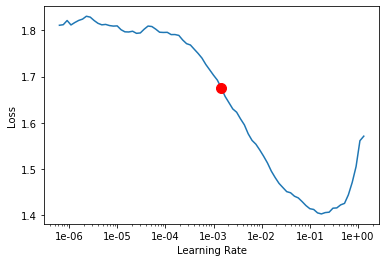

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

Initial training of the classifier. Increase in accuracy from epoch 1 to epoch 2.

In [ ]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.014255,0.946059,0.586933,08:11
1,0.957335,0.909459,0.604800,08:14


Training of last 2 layers with a range of learning rates (indicated by slice) and momentum vector 0.8 and 0.7.

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.947155,0.876505,0.618200,08:45
1,0.913976,0.826500,0.641267,08:19
2,0.805547,0.805290,0.646600,08:02
3,0.691287,0.821798,0.649400,09:51


Train and test (validation) plots against iterations of the Classifier

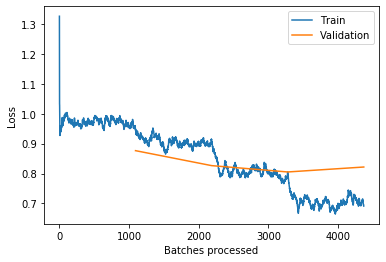

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('learn_model')

## Evaluating model on the Kaggle Test set

Here we choose the model of choice from above section which seems to be the Neural network and our text pre processing to evaluate the model performance interms of accuracy on the test data in the kaggle competition site

In [ ]:
test_data = pd.read_csv("/content/drive/My Drive/ADA_Assignment 2/test_data.csv")
test_data.head()

,test_id,text
0,test_1,trying to have a nice quiet dinner. the annou...
1,test_2,Been getting food to go from here for over 3yr...
2,test_3,Ugh. I've had to eat here a couple of times be...
3,test_4,The people here are so nice! I ordered on eat ...
4,test_5,Heard alot of good things about this place and...


In [ ]:
data_clas.add_test(items=test_data["text"],label=None)

Generating predictions on the test data

In [ ]:
preds,target = learn.get_preds(ds_type = DatasetType.Test, ordered=True)

In [ ]:
labels=np.argmax(preds,axis=1)

Saving it to a dataframe

In [ ]:
test_pred=pd.DataFrame()
test_pred['test_id']=test_data['test_id']
#se = pd.Series(log_reg2)
test_pred['label'] =labels
test_pred["label"]+=1
test_pred.head()

,test_id,label
0,test_1,3
1,test_2,4
2,test_3,1
3,test_4,5
4,test_5,4


In [ ]:
drive.mount('/content/drive')
export_csv = test_pred.to_csv (r'/content/drive/My Drive/ADA_Assignment 2/predict_label.csv', index = None, header=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Semi-Supervised Learning

All the models that we have built were supervised models (only with labeled data). In this part we are going to include unlabaled data for training the models with further data points. In each iteration we predict 10000 data points from unlabeled data and add those points to the training data, we then use the new training data to train the model and use it to predict another 10000 data points. we will test each iteration and monitor to see if the performance of the model is actualy improving or not.


### Simple Neural Network - Keras

We are going to use Keras neural network for training the unlabeled data.

In [ ]:
def accuracy(list1,list2):
    match=0
    for i in range(len(list1)):
        if list1[i]==list2[i]:
            match+=1
    return (match/len(list1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_labeled, text.iloc[0:50000]["label"], test_size=0.2, random_state = 200)

In [ ]:
x_tmp = X_train

y_tmp = y_train

df_unlabeled_matrix = df_unlabeled

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [ ]:
np.random.seed(5)  # make example repeatable 
                    
count = 0   

while(df_unlabeled_matrix.get_shape()[0]>0):
  
  print(df_unlabeled_matrix.get_shape())
  
  if count == 10:
        break    # break here
      
  # random sample    
  random_idxs= np.random.choice(df_unlabeled_matrix.get_shape()[0], size=10000, replace=False)
  
  # Using the indexes to slice the matrixes
  tmp_unlabeled = df_unlabeled_matrix[random_idxs, :]
  
  ########### MODEL TRAIN ###############################
  print("START TRAINING")
  
  model = Sequential()
  model.add(Dense(31, activation='relu', input_dim=input_dim))
  model.add(Dense(6, activation='softmax'))
  sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 
  model.fit(x_tmp, y_tmp, epochs=30,validation_data=(X_test, y_test), verbose=False, batch_size=128, shuffle="batch" )

  print("END TRAINING")
  
  # Print accuracy
  loss, accuracyTest = model.evaluate(X_test, y_test, verbose=False)
  print("Testing Accuracy:  {:.4f}".format(accuracyTest))
  
  ########### END MODEL TRAIN ###########################
    
  ## predict
  NN_predict=model.predict_classes(tmp_unlabeled)
 
  # add the predicted documets in the train data
  x_tmp=vstack((x_tmp, tmp_unlabeled))
  
  # add pseudo Label
  y_tmp = np.concatenate((np.array(y_tmp), np.array(NN_predict)), axis=None)
   
  
  temp=[x for x in range(df_unlabeled_matrix.get_shape()[0])]
  
  y=list(set(temp).symmetric_difference(random_idxs))
  
  #remove trained data points from unlabeled 
  df_unlabeled_matrix=df_unlabeled_matrix[y,:]
 
  count = count+1

(600000, 10000)
START TRAINING
END TRAINING
Testing Accuracy:  0.6131
(590000, 10000)
START TRAINING
END TRAINING
Testing Accuracy:  0.6097
(580000, 10000)
START TRAINING
END TRAINING
Testing Accuracy:  0.6090
(570000, 10000)
START TRAINING
END TRAINING
Testing Accuracy:  0.6069
(560000, 10000)
START TRAINING
END TRAINING
Testing Accuracy:  0.6063
(550000, 10000)
START TRAINING
END TRAINING
Testing Accuracy:  0.6041
(540000, 10000)
START TRAINING
END TRAINING
Testing Accuracy:  0.6060
(530000, 10000)
START TRAINING
END TRAINING
Testing Accuracy:  0.6039
(520000, 10000)
START TRAINING
END TRAINING
Testing Accuracy:  0.6022
(510000, 10000)
START TRAINING
END TRAINING
Testing Accuracy:  0.6035
(500000, 10000)


After 10 iterations or training 100 000 data points from the unlabeled data, we can see that the accuracy is dropping. 
From 0.6131 in the 1st iteration, the accuracy drops to 0.6035 in the 10th iteration. In all 10 iterations the accuracy drop for 0.0096.

### Logistic Regression 
In this part, we are going to repeat the same process but using Logistic Regression.

In [ ]:
x_tmp = X_train

y_tmp = y_train

df_unlabeled_matrix = df_unlabeled

In [ ]:
np.random.seed(5)  # make example repeatable 
                    
count = 0   

while(df_unlabeled_matrix.get_shape()[0]>0):
  
  print(df_unlabeled_matrix.get_shape())
  
  if count == 10:
        break    # break here
      
  # random sample    
  random_idxs= np.random.choice(df_unlabeled_matrix.get_shape()[0], size=10000, replace=False)
  
  # Using the indexes to slice the matrixes
  tmp_unlabeled = df_unlabeled_matrix[random_idxs, :]
  
  ########### MODEL TRAIN ###############################
  print("START TRAINING")
  
  lr2 = LogisticRegression(random_state=0, solver='newton-cg', C=0.6, class_weight="balanced", fit_intercept=False, max_iter=250, penalty="l2",tol=0.0001,multi_class='multinomial').fit(x_tmp, y_tmp)
  lr_predict2=lr2.predict(tmp_unlabeled)
  print(accuracy(lr2.predict(X_test),y_test.values))

  print("END TRAINING")
  
  ########### END MODEL TRAIN ###########################
   
  # add the predicted documets in the train data
  x_tmp=vstack((x_tmp, tmp_unlabeled))
  
  # add pseudo Label
  y_tmp = np.concatenate((np.array(y_tmp), np.array(lr_predict2)), axis=None)
   
  
  temp=[x for x in range(df_unlabeled_matrix.get_shape()[0])]
  
  y=list(set(temp).symmetric_difference(random_idxs))
  
  #remove trained data points from unlabeled 
  df_unlabeled_matrix=df_unlabeled_matrix[y,:]
 
  count = count+1

(600000, 10000)
START TRAINING
0.6036
END TRAINING
(590000, 10000)
START TRAINING
0.6003
END TRAINING
(580000, 10000)
START TRAINING
0.5967
END TRAINING
(570000, 10000)
START TRAINING
0.5959
END TRAINING
(560000, 10000)
START TRAINING
0.5955
END TRAINING
(550000, 10000)
START TRAINING
0.5939
END TRAINING
(540000, 10000)
START TRAINING
0.5944
END TRAINING
(530000, 10000)
START TRAINING
0.5938
END TRAINING
(520000, 10000)
START TRAINING
0.5925
END TRAINING
(510000, 10000)
START TRAINING
0.5926
END TRAINING
(500000, 10000)


We can see a similar outcome as using simple Neural Network. The accuracy is decreasing in first iteration the accuracy is 0.6030 and in the 10th iteration, the accuracy is 0.5926, in 10 iterations the accuracy drop for 0.0104.

# References

Aditya, C.(2019). Using FastAI’s ULMFiT to make a state-of-the-art multi-label text classifier. https://medium.com/technonerds/using-fastais-ulmfit-to-make-a-state-of-the-art-multi-label-text-classifier-bf54e2943e83

Jake, V. P. (2016) In Depth: Principal Component Analysis. https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Javaid, N.(2019).Machine Learning — Text Classification, Language Modelling using fast.ai.https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d

Kavita, G. (2018). Tutorial: Extracting Keywords with TF-IDF and Python’s Scikit-Learn.https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.XbBFm-gzZPY

Prajwal, S.(2019). Sentiment analysis for text with Deep Learning. https://towardsdatascience.com/sentiment-analysis-for-text-with-deep-learning-2f0a0c6472b5

Prateek, J. (2018). Tutorial on Text Classification (NLP) using ULMFiT and fastai Library in Python. https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/

Sebastian, R. & Julian, E.(2019). Efficient multi-lingual language model fine-tuning. http://nlp.fast.ai/

Usman, M. (2019). Python for NLP: Movie Sentiment Analysis using Deep Learning in Keras. https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

